##まとめ
* Embeddingレイヤは単語の分散表現を格納し、順伝播において該当する単語IDのベクトルを抽出する
* word2vecでは語彙数の増加に比例して計算量が増加するので、近似計算を行う高速な手法を使うと良い
* Negative Samplingは負例をいくつかサンプリングする手法であり、これを利用すれば多値分類を二値分類として扱うことができる
* word2vecによって得られた単語の分散表現は、単語の意味が埋め込まれたものであり、似たコンテキストで使われる単語は単語ベクトルの空間上で近い場所に位置するようになる
* word2vecの単語の分散表現は、類推問題をベクトルの加算と減算によって解ける性質を持つ
* word2vecは転移学習の点で特に重要であり、その単語の分散表現はさまざまな自然言語処理のタスクに利用できる

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL_2'
sys.path.append(ROOT_PATH)

Mounted at /content/drive


##word2vecの改良①
巨大なコーパスを扱う上で、下記2箇所の計算がボトルネックとなる  

* 入力層のone-hot表現と重み行列$\mathrm {W_{in}}$の積による計算（Embeddingレイヤにより解決）
* 中間層と重み行列$\mathrm {W_{out}}$の積及びSoftmaxレイヤの計算(Negative Samplingにより解決)


###Embeddingレイヤ
巨大なone-hot行列と重み行列との積の計算は、重みパラメータから単語IDに該当する行を抜き出すことと同じ  
Embeddingレイヤは、重みパラメータから単語IDに該当する行を抜き出し、単語の分散表現を格納するレイヤ

In [ ]:
class Embedding:
    def __init__(self,W):
        self.params=[W]
        # print(self.params)
        self.grads=[np.zeros_like(W)]
        self.idx=None

    def forward(self,idx):
        W,=self.params  #W=self.paramsだとWにリストが格納されるので','をつけてリストの0番目の要素をWに格納
        # print(W)
        self.idx=idx
        # print(idx)
        out=W[idx]
        return out

    def backward(self,dout):
        dW,=self.grads
        dW[...]=0   #補足参照
        
        if GPU:
            np.scatter_add(dW, self.idx, dout)
        else:
            # dW[self.idx]=dout #←重複したidxに対応できない誤った実装
            # for i,word_id in enumerate(self.idx): #正しいが処理が遅い実装
            #     dout[word_id]+=dout[i]

            #重複したidxの要素は加算する
            np.add.at(dW, self.idx, dout)
            
        return None

In [ ]:
from common.util import preprocess,create_contexts_target,convert_one_hot

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)

vocab_size=len(word_to_id)
window_size=1
contexts,target=create_contexts_target(corpus,window_size)
print('target\n',target)
print('\ncontexts\n',contexts)

hidden_size=3
W_in=0.01*np.random.randn(vocab_size,hidden_size)

print('\nW_in\n',W_in)

layer=Embedding(W_in)
out=layer.forward(idx=contexts[0,1])

print('\nout\n',out)

target
 [1 2 3 4 1 5]

contexts
 [[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]

W_in
 [[-0.0112124   0.00650287  0.01557271]
 [ 0.00344513 -0.00380371 -0.00664803]
 [-0.0110102   0.00923043 -0.01056208]
 [ 0.00019928 -0.00869983  0.01454573]
 [ 0.00539738  0.00110524 -0.00458298]
 [-0.00306227 -0.01067512  0.0059613 ]
 [-0.0026683   0.0053289  -0.00094852]]

out
 [-0.0110102   0.00923043 -0.01056208]


####補足

In [8]:
import numpy as np

y=[np.array([1,2,3])]
z=y
a,=y
print(z)
print(a)

x=np.array([1,2,3])
dW=x    #dWとxは浅いコピー（メモリの場所が同じ）
print(x)
print(dW)

dW[...]=0    #(...):Ellipsis

print(x)
print(dW)

[array([1, 2, 3])]
[1 2 3]
[1 2 3]
[1 2 3]
[0 0 0]
[0 0 0]


##word2vecの改良②
* 中間層と重み行列$\mathrm {W_{out}}$の積及びSoftmaxレイヤの計算(Negative Samplingにより解決)

###多値分類から二値分類へ
* 多値分類  
    「コンテキストが『you』と『goodbye』のとき、ターゲットは何ですか？」  
    ネットワークの出力層のニューロン数は語彙数
* 二値分類(yes/noで答えられる問題)  
    「コンテキストが『you』と『goodbye』のとき、ターゲットは『say』ですか？」  
    ネットワークの出力層のニューロン数はひとつ（上の例だと『say』のみ）


###シグモイド関数と交差エントロピー誤差
二値分類の問題を解くには、スコアにシグモイド関数を適用し、確率を得る  
そして損失を求めるために、損失関数として交差エントロピー誤差を適用する  
* シグモイド関数  
$$
y=\dfrac{1}{1+\exp(-x)}
$$  
シグモイド関数は０から１の値をとるため、確率として解釈できる
* 二値分類の交差エントロピー誤差  
$$
L=-(t\log y+(1-t)\log (1-y))
$$  
正解ラベル$t$が１の場合はスコア$y$(正解の確率)の対数をとりマイナスをかける  
正解ラベル$t$が0の場合はスコア$y$を１から引いた値（不正解の確率）の対数をとりマイナスをかける  
シグモイド関数＋交差エントロピー誤差の逆伝搬では、ソフトマックス関数＋交差エントロピー誤差と同じく$y-t$の値が伝搬する  
（恒等関数＋二乗和誤差も$y-t$が伝搬する）



In [ ]:
from common.functions import cross_entropy_error

class SigmoidWithLoss:
    def __init__(self):
        self.params,self.grads=[],[]
        self.loss=None
        self.y=None
        self.t=None

    def forward(self,x,t):
        self.y=1/(1+np.exp(-x))
        self.t=t

        #t=0(負例)の場合はnp.c_[1-self.y,self.y][0]、すなわち1-self.yの確率を使用して交差エントロピー誤差を計算する
        #t=0 or 1のため、tの値がそのままnp.c_[1-self.y,self.y]のインデックスになる
        self.loss=cross_entropy_error(np.c_[1-self.y,self.y],self.t)
        return self.loss

    def backward(self,dout=1):
        batch_size=self.t.shape[0]
        dx=(self.y-self.t)/batch_size*dout

        return dx

In [ ]:
h=np.random.randn(1)
print('h\n',h)
t=np.array([1])
print('\nt\n',t)

layer=SigmoidWithLoss()
loss=layer.forward(h,t)
print('\nloss\n',loss)

h
 [-1.34054986]

t
 [1]

loss
 1.5730107687022772


###多値分類から二値分類へ（実装編）

In [ ]:
class EmbeddingDot:
    def __init__(self,W):
        self.embed=Embedding(W)
        self.params=self.embed.params
        self.grads=self.embed.grads

    def forward(self,h,idx):
        target_W=self.embed.forward(idx)
        out=np.sum(target_W*h,axis=1)
        self.cache=(h,target_W)
        return out

    def backward(self,dout):
        h,target_W=self.cache
        dout=dout.reshape(dout.shape[0],1)  #dtarget_Wh=np.ones(dout.shape[0],1)*dout
        dtarget_W=dout*h
        self.embed.backward(dtarget_W)
        dh=dout*target_W
        return dh

In [ ]:
from common.util import preprocess,create_contexts_target,convert_one_hot
from common.config import GPU

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)

vocab_size=len(word_to_id)
window_size=1
contexts,target=create_contexts_target(corpus,window_size)
print(target)
print(contexts[0:1,1])

hidden_size=3
W_in=0.01*np.random.randn(vocab_size,hidden_size)
W_out=0.01*np.random.randn(vocab_size,hidden_size)

in_layer0=Embedding(W_in)
in_layer1=Embedding(W_in)
out_layer=EmbeddingDot(W_out)

print('W_in\n',in_layer0.params)
print('W_out\n',out_layer.params)

#forward
h0=in_layer0.forward(idx=contexts[0:2,0])
print('h0\n',h0)
h1=in_layer1.forward(idx=contexts[0:2,1])
print('h1\n',h1)
h=0.5*(h0+h1)
print('h\n',h)
out=out_layer.forward(h,idx=target[0:2])
print('out\n',out)

#backward
dout=np.ones(*out.shape)
print('dout\n',dout)
dh_avg=out_layer.backward(dout)
print('dW_out\n',out_layer.grads)
print('dh_avg\n',dh_avg)
dh=0.5*dh_avg
print('dh\n',dh)
in_layer0.backward(dh)
print('dW_in\n',in_layer0.grads)
in_layer1.backward(dh)
print('dW_in\n',in_layer1.grads)

[1 2 3 4 1 5]
[2]
W_in
 [array([[ 0.02239392,  0.01030596, -0.0042481 ],
       [ 0.0079959 , -0.00104849, -0.01399016],
       [ 0.01288037, -0.02025115,  0.00154218],
       [-0.00540703, -0.01441999, -0.00316171],
       [ 0.00812903, -0.02215768,  0.0025718 ],
       [-0.01320067, -0.00877354, -0.00450379],
       [-0.00822057, -0.00316135,  0.00473469]])]
W_out
 [array([[-0.00651368,  0.01258207, -0.00323875],
       [ 0.00468141, -0.01123873, -0.00035966],
       [ 0.01488415, -0.00533371,  0.01297541],
       [ 0.0029728 , -0.01077835,  0.00636749],
       [-0.0022478 ,  0.00523195,  0.02197696],
       [ 0.00257876, -0.00842647,  0.02115772],
       [-0.00259693, -0.00713784, -0.00574596]])]
h0
 [[ 0.02239392  0.01030596 -0.0042481 ]
 [ 0.0079959  -0.00104849 -0.01399016]]
h1
 [[ 0.01288037 -0.02025115  0.00154218]
 [-0.00540703 -0.01441999 -0.00316171]]
h
 [[ 0.01763714 -0.0049726  -0.00135296]
 [ 0.00129444 -0.00773424 -0.00857594]]
out
 [ 1.38939028e-04 -5.07574555e-05]
dout

##Negative Sampling
* 正例をターゲットとした場合の損失を求めると同時に、負例をいくつか（5〜10個）サンプリングし（選び出し）、その負例に対しても損失を求める
* それぞれのデータ（正例とサンプリングされた負例）における損失を足し合わせ、その結果を最終的な損失にする

In [ ]:
import collections

class UnigramSampler:
    '''
    vocab_size(語彙数)のカウント、negative_sample(負例)の選択確率の導出、負例の選択を行う
    '''
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        #vocab_size(語彙数)をカウントする
        counts = collections.Counter()  #配列の各要素の個数をカウントして辞書化するクラス{you:3,say:4,...}
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        #各語彙の確率分布(word_p)を求める
        self.word_p = np.zeros(vocab_size)  #語彙数分の行列を用意する
        for i in range(vocab_size):
            self.word_p[i] = counts[i]  #各語彙のカウントした数を代入する

        self.word_p = np.power(self.word_p, power)  #各数のpower乗をとる.低い確率を少し底上げする（例：power=0.75）
        self.word_p /= np.sum(self.word_p)  #power乗した個数の総和で割り、確率化する

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()  #確率分布配列を深いコピー
                target_idx = target[i]  #正例のミニバッチのi番目の要素（word_id）をtarget_idxに代入
                p[target_idx] = 0   #正例の確率を０にする
                p /= p.sum()    #各確率を負例の選択確率として再計算
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)    #確率分布に従って負例を選択する
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [ ]:
from common.util import preprocess,create_contexts_target
# from common.config import GPU

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)
print('corpus\n',corpus)

vocab_size=len(word_to_id)
window_size=1
contexts,target=create_contexts_target(corpus,window_size)
print('\ntarget\n',target)

sampler=UnigramSampler(corpus,power=0.75,sample_size=3)
word_p=sampler.word_p
print('\nword_p\n',word_p)
negative_sample=sampler.get_negative_sample(target)
print('\nnegative_sample\n',negative_sample)

corpus
 [0 1 2 3 4 1 5 6]

target
 [1 2 3 4 1 5]

word_p
 [0.13017794 0.21893233 0.13017794 0.13017794 0.13017794 0.13017794
 0.13017794]

negative_sample
 [[0 6 2]
 [6 4 1]
 [5 2 0]
 [5 1 0]
 [5 0 6]
 [6 2 4]]


###Negative Samplingの実装

In [ ]:
class NegativeSamplingLoss:
    def __init__(self,W,corpus,power=0.75,sample_size=5):
        self.sample_size=sample_size
        self.sampler=UnigramSampler(corpus,power,sample_size)
        self.loss_layers=[SigmoidWithLoss() for _ in range(sample_size+1)]   #負例サンプルサイズ＋正例用のレイヤひとつを生成
        self.embed_dot_layers=[EmbeddingDot(W) for _ in range(sample_size+1)]   #負例サンプルサイズ＋正例用のレイヤひとつを生成

        self.params,self.grads=[],[]
        for layer in self.embed_dot_layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def forward(self,h,target):
        batch_size=target.shape[0]
        negative_sample=self.sampler.get_negative_sample(target)

        #正例のフォワード
        score=self.embed_dot_layers[0].forward(h,target)    #最初のレイヤを正例用のレイヤとして使用する
        correct_label=np.ones(batch_size,dtype=np.int32)    #正解ラベル1をバッチ数だけ用意する
        loss=self.loss_layers[0].forward(score,correct_label)
        
        #負例のフォワード
        negative_label=np.zeros(batch_size,dtype=np.int32)  #不正解ラベル０をバッチ数だけ用意する
        for i in range(self.sample_size):
            negative_target=negative_sample[:,i]
            score=self.embed_dot_layers[1+i].forward(h,negative_target)
            loss+=self.loss_layers[1+i].forward(score,negative_label)

        return loss

    def backward(self,dout=1):
        dh=0
        for l0,l1 in zip(self.loss_layers,self.embed_dot_layers):
            dscore=l0.backward(dout)
            dh+=l1.backward(dscore)

        return dh

In [ ]:
from common.util import preprocess,create_contexts_target,convert_one_hot

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)

vocab_size=len(word_to_id)
window_size=1
contexts,target=create_contexts_target(corpus,window_size)

hidden_size=3
W_in=0.01*np.random.randn(vocab_size,hidden_size)
W_out=0.01*np.random.randn(vocab_size,hidden_size)

in_layer0=Embedding(W_in)
in_layer1=Embedding(W_in)
out_layer=NegativeSamplingLoss(W_out,corpus,sample_size=3)

print('W_in\n',in_layer0.params[0])
print('W_out\n',out_layer.params[0])

#forward
h0=in_layer0.forward(contexts[0:2,0])
print('h0\n',h0)
h1=in_layer1.forward(contexts[0:2,1])
print('h1\n',h1)
h=0.5*(h0+h1)
print('h\n',h)
out=out_layer.forward(h,target[0:2])
print('out\n',out)

# backward
dout=1
print('\ndout\n',dout)
dh=out_layer.backward(dout)
print('\ndh\n',dh)
print('\ndW_out\n',out_layer.grads[0])

in_layer0.backward(dh)
print('\ndW_in\n',in_layer0.grads[0])
in_layer1.backward(dh)
print('\ndW_in\n',in_layer1.grads[0])

W_in
 [[ 4.78111906e-04 -3.74395841e-03  1.52111374e-03]
 [ 4.34413829e-03 -7.79731165e-03  4.73877140e-03]
 [ 1.65566564e-02 -3.92448965e-03 -5.28882672e-05]
 [-6.26095093e-03  2.51586769e-03 -1.26262878e-02]
 [ 2.54682579e-03 -7.98158619e-05  1.76796587e-02]
 [-3.43766003e-03  9.95298843e-03  2.78008071e-03]
 [ 7.33670276e-03  8.93046956e-03 -4.27715125e-03]]
W_out
 [[-0.00241956  0.00222328  0.01935208]
 [ 0.00162047  0.01211012  0.01207752]
 [-0.00040469 -0.00216068 -0.00283483]
 [-0.01090643  0.00410722 -0.01410612]
 [-0.00443477  0.0071535  -0.01623324]
 [-0.01756048 -0.00241587  0.00012163]
 [ 0.00302546  0.00772306 -0.01636314]]
h0
 [[ 0.00047811 -0.00374396  0.00152111]
 [ 0.00434414 -0.00779731  0.00473877]]
h1
 [[ 1.65566564e-02 -3.92448965e-03 -5.28882672e-05]
 [-6.26095093e-03  2.51586769e-03 -1.26262878e-02]]
h
 [[ 0.00851738 -0.00383422  0.00073411]
 [-0.00095841 -0.00264072 -0.00394376]]
out
 2.7725693556187947

dout
 1

dh
 [[-0.00085859  0.00015132 -0.01187703]
 [ 0.0

##改良版word2vecの学習

###CBOWモデルの実装

In [ ]:
class CBOW:
    def __init__(self,vocab_size,hidden_size,window_size,corpus):
        V,H=vocab_size,hidden_size

        #重みの初期化
        W_in=0.01*np.random.randn(V,H).astype('f')
        W_out=0.01*np.random.randn(V,H).astype('f')

        #レイヤの生成
        self.in_layers=[]
        for i in range(2*window_size):  #window_sizeの２倍（左側と右側,=contextsの数）だけEmbeddingレイヤを用意する
            layer=Embedding(W_in)
            self.in_layers.append(layer)
        
        self.ns_loss=NegativeSamplingLoss(W_out,corpus,power=0.75,sample_size=5)

        #パラメータの格納
        self.params,self.grads=[],[]
        layers=self.in_layers+[self.ns_loss]

        for layer in layers:
            self.params+=layer.params
            self.grads+=layer.grads

        #メンバ変数に単語の分散表現を設定
        self.word_vecs=W_in

    def forward(self,contexts,target):
        h=0
        for i,layer in enumerate(self.in_layers):
            h+=layer.forward(contexts[:,i])
        h*=1/len(self.in_layers)    #出力の総和をコンテキスト数で割って平均を取る
        loss=self.ns_loss.forward(h,target)
        return loss

    def backward(self,dout=1):
        dout=self.ns_loss.backward(dout)
        dout*=1/len(self.in_layers) #乗算ノードの逆伝搬
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [ ]:
from common import config
from common.np import *
# config.GPU=True
from common.util import preprocess,create_contexts_target,to_cpu,to_gpu
from common.optimizer import Adam
from dataset import ptb

window_size=5
hidden_size=100
batch_size=100
max_epoch=10

text="Minecraft is a sandbox video game developed by Mojang. The game was created by Markus 'Notch' Persson in the Java programming language. Following several early test versions, it was released as a paid public alpha for personal computers in 2009 before releasing in November 2011, with Jens Bergensten taking over development. Minecraft has since been ported to several other platforms and is the best-selling video game of all time, with 200 million copies sold and 126 million monthly active users as of 2020.In Minecraft, players explore a blocky, procedurally-generated 3D world with infinite terrain, and may discover and extract raw materials, craft tools and items, and build structures or earthworks. Depending on game mode, players can fight computer-controlled 'mobs', as well as cooperate with or compete against other players in the same world. Game modes include a survival mode, in which players must acquire resources to build the world and maintain health, and a creative mode, where players have unlimited resources. Players can modify the game to create new gameplay mechanics, items, and assets.Minecraft has been critically acclaimed, winning several awards and being cited as one of the greatest video games of all time. Social media, parodies, adaptations, merchandise, and the annual MineCon conventions played large roles in popularizing the game. It has also been used in educational environments, especially in the realm of computing systems, as virtual computers and hardware devices have been built in it. In 2014, Mojang and the Minecraft intellectual property were purchased by Microsoft for US$2.5 billion. A number of spin-off games have also been produced, such as Minecraft: Story Mode, Minecraft Dungeons, and Minecraft Earth."
corpus,word_to_id,id_to_word=preprocess(text)
# corpus,word_to_id,id_to_word=ptb.load_data('train')
vocab_size=len(word_to_id)

contexts,target=create_contexts_target(corpus,window_size)

iters_per_epoch=len(target)//batch_size
max_iter=max_epoch*iters_per_epoch

# print('target\n',target)
# print('\ncontexts\n',contexts)

if config.GPU:
    contexts,target=to_gpu(contexts),to_gpu(target)

model=CBOW(vocab_size,hidden_size,window_size,corpus)
optimizer=Adam()

loss_list=[]
for epoch in range(max_epoch):
    for i in range(iters_per_epoch):
        batch_idx=np.random.choice(np.arange(len(target)),batch_size)
        # print('\nbatch_idx\n',batch_idx)
        target_batch=target[batch_idx]
        contexts_batch=contexts[batch_idx]
        # print('\ntarget_batch\n',target_batch)
        # print('\ncontexts_batch\n',contexts_batch)
        loss=model.forward(contexts_batch,target_batch)
        model.backward()
        optimizer.update(model.params,model.grads)
        
    loss_list.append(loss)
    print('loss:',loss)
    # print(model.word_vecs)

loss: 4.1584728240966795
loss: 4.15671630859375
loss: 4.149611816406249
loss: 4.134226531982422
loss: 4.104995193481446
loss: 4.063831176757812
loss: 3.9930577850341793
loss: 3.8944548034667967
loss: 3.7870541381835943
loss: 3.6656522750854488


In [ ]:
from common.util import most_similar

querys=list(word_to_id.keys())
print(querys)

for query in querys:
    most_similar(query,word_to_id,id_to_word,model.word_vecs,top=5)

['minecraft', 'is', 'a', 'sandbox', 'video', 'game', 'developed', 'by', 'mojang', '.', 'the', 'was', 'created', 'markus', "'notch'", 'persson', 'in', 'java', 'programming', 'language', 'following', 'several', 'early', 'test', 'versions,', 'it', 'released', 'as', 'paid', 'public', 'alpha', 'for', 'personal', 'computers', '2009', 'before', 'releasing', 'november', '2011,', 'with', 'jens', 'bergensten', 'taking', 'over', 'development', 'has', 'since', 'been', 'ported', 'to', 'other', 'platforms', 'and', 'best-selling', 'of', 'all', 'time,', '200', 'million', 'copies', 'sold', '126', 'monthly', 'active', 'users', '2020', '.in', 'minecraft,', 'players', 'explore', 'blocky,', 'procedurally-generated', '3d', 'world', 'infinite', 'terrain,', 'may', 'discover', 'extract', 'raw', 'materials,', 'craft', 'tools', 'items,', 'build', 'structures', 'or', 'earthworks', 'depending', 'on', 'mode,', 'can', 'fight', 'computer-controlled', "'mobs',", 'well', 'cooperate', 'compete', 'against', 'same', 'mode

###CBOWモデルの学習コード

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 0[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 0[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 0[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 0[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 1[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 1[s] | loss 3.62
| epoch 1 |  iter 161 / 9295 | time 1[s] | loss 3.50
| epoch 1 |  iter 181 / 9295 | time 1[s] | loss 3.37
| epoch 1 |  iter 201 / 9295 | time 1[s] | loss 3.25
| epoch 1 |  iter 221 / 9295 | time 1[s] | loss 3.17
| epoch 1 |  iter 241 / 9295 | time 2[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 2[s] | loss 3.04
| epoch 1 |  iter 281 / 9295 | time 2[s] | loss 2.99
| epoch 1 |  iter 301 / 9295 | time 2[s] | loss 2.94
| epoch 1 |  iter 321 / 9295 | time 2[s] | loss 2.89
| epoch 1 |  iter 341 / 9295 | time 2[s] | loss 2.85
| epoch 1 |  iter 361 / 9295 | time 3[s] | loss 2.82

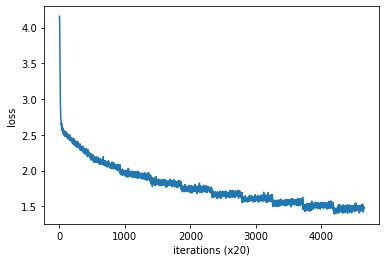

In [ ]:
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
config.GPU = True
# ===============================================
from common.np import *
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from common.util import preprocess,create_contexts_target, to_cpu, to_gpu,most_similar
from dataset import ptb

window_size=5
hidden_size=100
batch_size=100
max_epoch=10

# text='You say goodbye and I say hello.'
# corpus,word_to_id,id_to_word=preprocess(text)

# text="Minecraft is a sandbox video game developed by Mojang. The game was created by Markus 'Notch' Persson in the Java programming language. Following several early test versions, it was released as a paid public alpha for personal computers in 2009 before releasing in November 2011, with Jens Bergensten taking over development. Minecraft has since been ported to several other platforms and is the best-selling video game of all time, with 200 million copies sold and 126 million monthly active users as of 2020.In Minecraft, players explore a blocky, procedurally-generated 3D world with infinite terrain, and may discover and extract raw materials, craft tools and items, and build structures or earthworks. Depending on game mode, players can fight computer-controlled 'mobs', as well as cooperate with or compete against other players in the same world. Game modes include a survival mode, in which players must acquire resources to build the world and maintain health, and a creative mode, where players have unlimited resources. Players can modify the game to create new gameplay mechanics, items, and assets.Minecraft has been critically acclaimed, winning several awards and being cited as one of the greatest video games of all time. Social media, parodies, adaptations, merchandise, and the annual MineCon conventions played large roles in popularizing the game. It has also been used in educational environments, especially in the realm of computing systems, as virtual computers and hardware devices have been built in it. In 2014, Mojang and the Minecraft intellectual property were purchased by Microsoft for US$2.5 billion. A number of spin-off games have also been produced, such as Minecraft: Story Mode, Minecraft Dungeons, and Minecraft Earth."
# corpus,word_to_id,id_to_word=preprocess(text)

corpus,word_to_id,id_to_word=ptb.load_data('train')
vocab_size=len(word_to_id)
contexts,target=create_contexts_target(corpus,window_size)

if config.GPU:
    contexts,target=to_gpu(contexts),to_gpu(target)

model=CBOW(vocab_size,hidden_size,window_size,corpus)
optimizer=Adam()
trainer=Trainer(model,optimizer)

trainer.fit(contexts,target,max_epoch,batch_size)
trainer.plot()

word_vecs=model.word_vecs

if config.GPU:
    word_vecs=to_cpu(word_vecs)
params={}
params['word_vecs']=word_vecs.astype(np.float16)
params['word_to_id']=word_to_id
params['id_to_word']=id_to_word
pkl_file=ROOT_PATH+'/ch04/cbow_params.pkl'
with open(pkl_file,'wb') as f:
    pickle.dump(params,f,-1)

###CBOWモデルの評価

In [5]:
from common.util import most_similar
import pickle

with open(ROOT_PATH+'/ch04/cbow_params.pkl','rb') as f:
    params=pickle.load(f)
    word_vecs=params['word_vecs']
    word_to_id=params['word_to_id']
    id_to_word=params['id_to_word']

querys=['glass','window','more','i']
for query in querys:
    most_similar(query,word_to_id,id_to_word,word_vecs,top=5)


[query]glass
plastic: 0.59228515625
water: 0.59033203125
tires: 0.5859375
displays: 0.57861328125
gum: 0.57568359375

[query]window
walls: 0.6923828125
tube: 0.65087890625
alarm: 0.6484375
village: 0.64111328125
ocean: 0.640625

[query]more
less: 0.8408203125
greater: 0.7529296875
rather: 0.73388671875
better: 0.7333984375
fewer: 0.693359375

[query]i
you: 0.71337890625
we: 0.64013671875
my: 0.56787109375
me: 0.5498046875
anybody: 0.505859375


In [29]:
from common.np import *

def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s is not found' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)    #正規化

    similarity = np.dot(word_matrix, query_vec) #コサイン類似度（正規化して内積をとる）

    if answer is not None:  #正解が与えられた場合は、正解とのコサイン類似度を表示
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():   #コサイン類似度を降順に並び替えたときの各インデックスが格納されたイタレータ
        if np.isnan(similarity[i]): #欠損値（nan）がある場合はスキップする
            continue
        if id_to_word[i] in (a, b, c):  #abcは答えに含めずにスキップする
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:    #countがtopに達したら終了
            return


def normalize(x):   #正規化
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

In [31]:
analogy('japan','japanese','america',word_to_id,id_to_word,word_vecs,top=5,answer='american')


[analogy] japan:japanese = america:?
==>american:3.271
 milestones: 5.91796875
 vice: 3.30078125
 american: 3.271484375
 bank-backed: 2.85546875
 latin: 2.822265625


In [20]:
x=np.array([[1,2,3],[2,3,4]])
print(x*x)
print((x*x).sum())
print((x*x).sum(1))
y=[[1,2,3],[3,4,5]]
print(y.sum(1))

[[ 1  4  9]
 [ 4  9 16]]
43
[14 29]


AttributeError: ignored